In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact

In [78]:
def plot_categorical_columns(df, column1, column2):
    """
    Plot two categorical columns against each other.
    
    Parameters:
    - df: pandas DataFrame
    - column1: str, name of the first categorical column
    - column2: str, name of the second categorical column
    """
    # Create a cross-tabulation of the two columns
    cross_tab = pd.crosstab(df[column1], df[column2])
    
    # Plot using seaborn's heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='d', cbar=True)
    
    # Set labels and title
    plt.xlabel(column2)
    plt.ylabel(column1)
    plt.title(f'Plot of {column1} vs {column2}')
    
    # Show the plot
    plt.show()

In [79]:
data = pd.read_csv('Data/brca_metabric_clinical_data.tsv', sep='\t', header=0)

If possible, breast conserving therapy (BCT) is to be favored over a complete removal of the breast (mastectomy). 

All BCT patients with invasive tumor types have to get radiation after the OP in order to minimize the risk of relapse.

Is this really the case with our data?

In [80]:
# Get data for all BCT patients with an invasive tumor type
invasive_cancer = data[data['Cancer Type Detailed'].str.contains('Invasive')]
bct = invasive_cancer[invasive_cancer['Type of Breast Surgery'] == 'BREAST CONSERVING']

In [82]:
#Check whether all of them had radio therapy
number_rt = sum(bct['Radio Therapy'] == 'YES')
number_no_rt = sum(bct['Radio Therapy'] == 'NO')

print('Proportion of BCT patients undergoing radio therapy:', round(number_rt/len(bct), 3), f'({number_rt}/{len(bct)})')
print('Proportion of BCT patients NOT undergoing radio therapy:', round(number_no_rt/len(bct), 3), f'({number_no_rt}/{len(bct)})')

Proportion of BCT patients undergoing radio therapy: 0.896 (623/695)
Proportion of BCT patients NOT undergoing radio therapy: 0.104 (72/695)


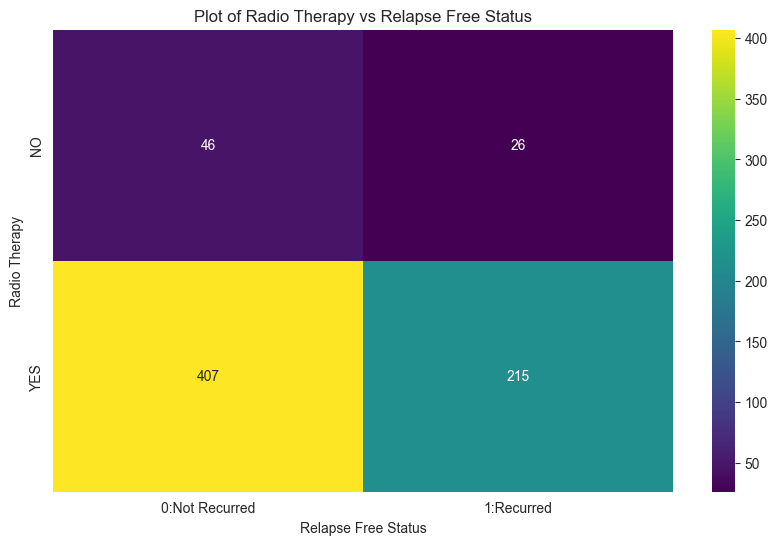

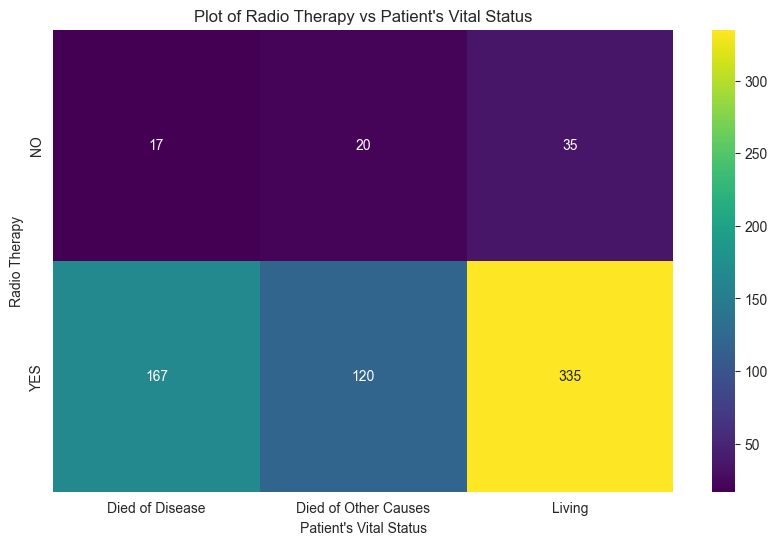

In [81]:
plot_categorical_columns(bct, 'Radio Therapy', 'Relapse Free Status')
plot_categorical_columns(bct, 'Radio Therapy', 'Patient\'s Vital Status')

We can see that ~10% of the BCT patients did not undergo the obligatory radio therapy. 
Do they have a higher risk of relapse/death?

In [100]:
# Divide data into BCT patient with and without radio therapy
rt = bct[bct['Radio Therapy'] == 'YES']
no_rt = bct[bct['Radio Therapy'] == 'NO']

relapse_rt = sum(rt['Relapse Free Status'] == '0:Not Recurred') / len(rt)
relapse_no_rt = sum(no_rt['Relapse Free Status'] == '0:Not Recurred') / len(no_rt)
print('Proportion of BCT patients undergoing radio therapy that did not relapse:', round(relapse_rt, 3))
print('Proportion of BCT patients NOT undergoing radio therapy that did not relapse:', round(relapse_no_rt, 3))

relapse_time_rt = np.mean(rt['Relapse Free Status (Months)'].values)
relapse_time_no_rt = np.mean(no_rt['Relapse Free Status (Months)'].values)
print('Mean relapse free status (months) BCT + RT', round(relapse_time_rt, 3))
print('Mean relapse free status (months) BCT only', round(relapse_time_no_rt, 3))

survival_rt = sum(rt['Patient\'s Vital Status'] == 'Died of Disease') / len(rt)
survival_no_rt = sum(no_rt['Patient\'s Vital Status'] == 'Died of Disease') / len(no_rt)
print('Proportion of BCT patients undergoing radio therapy that died from the disease:', round(survival_rt, 3))
print('Proportion of BCT patients NOT undergoing radio therapy that died from the disease:', round(survival_no_rt, 3))

print(sum((rt['Relapse Free Status'] == '1:Recurred') & (rt['Patient\'s Vital Status'] == 'Died of Disease') ) / len(rt))
print(sum((no_rt['Relapse Free Status'] == '1:Recurred') & (no_rt['Patient\'s Vital Status'] == 'Died of Disease') ) / len(no_rt))
no_rt_ht = sum(no_rt['Hormone Therapy'] == 'YES')
no_rt_no_ht = sum(no_rt['Hormone Therapy'] == 'NO')
# 
print(no_rt_ht, no_rt_no_ht)


Proportion of BCT patients undergoing radio therapy that did not relapse: 0.637
Proportion of BCT patients NOT undergoing radio therapy that did not relapse: 0.548
Mean relapse free status (months) BCT + RT 123.421
Mean relapse free status (months) BCT only 85.592
Proportion of BCT patients undergoing radio therapy that died from the disease: 0.261
Proportion of BCT patients NOT undergoing radio therapy that died from the disease: 0.387
0.260752688172043
0.3870967741935484
0 0


In [88]:
# Fisher's exact test
contingency_table = pd.crosstab(bct['Radio Therapy'], bct['Relapse Free Status'])
res = fisher_exact(contingency_table)
res.pvalue

0.794858380846403

Explained variation per principal component: [0.21302243 0.19639038 0.13108027]


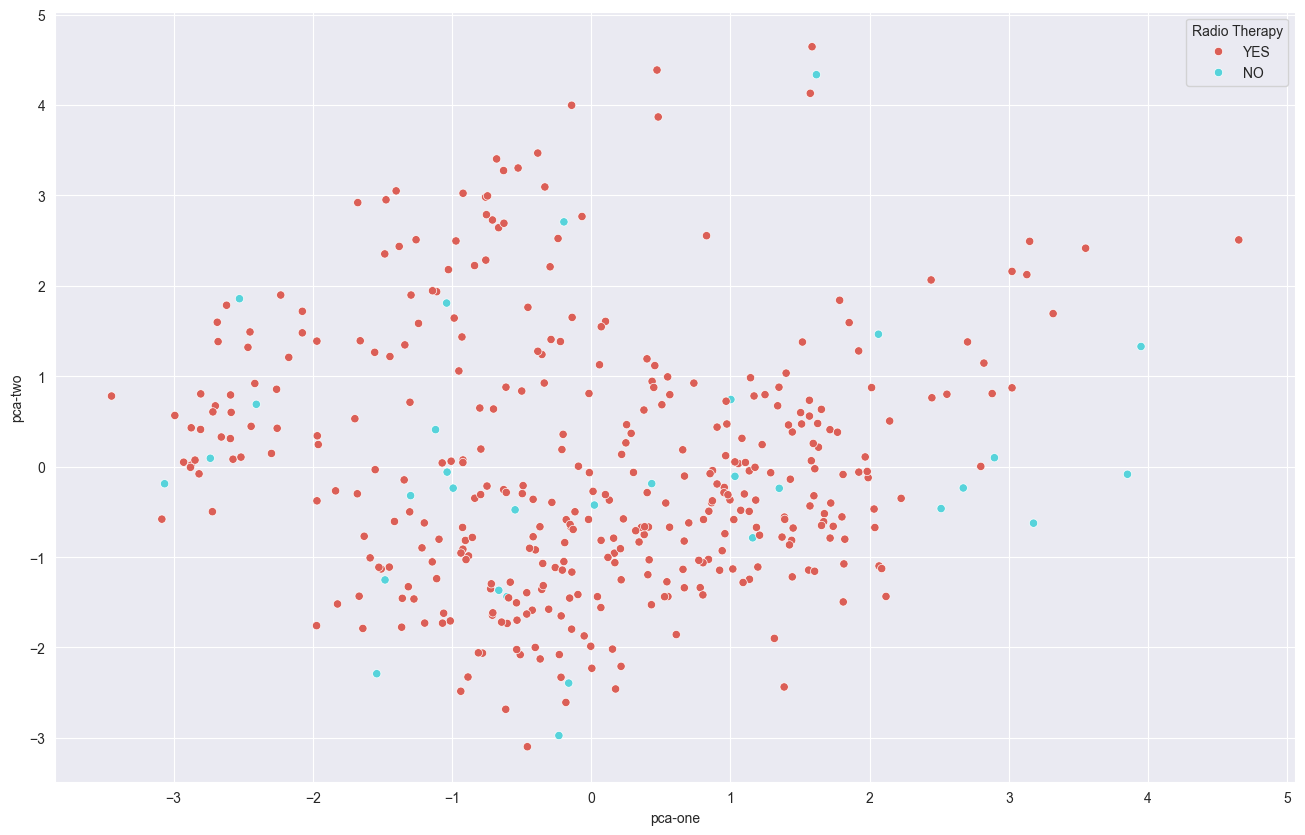

In [97]:
def PCA_Analysis(df, cols, coloring):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[cols].values)
    
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,1] 
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue=coloring,
        palette=sns.color_palette("hls", 2),
        data=df,
        legend="full",
        alpha=1
    )
    
    plt.show()
    

cols = ['Age at Diagnosis', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive', 'Mutation Count', 'Tumor Size',  'Tumor Stage', "Inferred Menopausal State", "HER2 Status", "Hormone Therapy", "PR Status"]
bct = bct.dropna()
label_encoder = preprocessing.LabelEncoder()
bct["Inferred Menopausal State"] = label_encoder.fit_transform(bct["Inferred Menopausal State"])
bct["HER2 Status"] = label_encoder.fit_transform(bct["HER2 Status"])
bct["Hormone Therapy"] = label_encoder.fit_transform(bct["Hormone Therapy"])
bct["PR Status"] = label_encoder.fit_transform(bct["PR Status"])


# Normalize data
scaler = preprocessing.StandardScaler()
bct[cols] = scaler.fit_transform(bct[cols].to_numpy())

PCA_Analysis(bct, cols=cols, coloring='Radio Therapy')
